## NeuroTac Spiking Neural Network Demo

Intro paragraph or something here

In [1]:
# Import libraries for data collection
import sys
sys.path.append("..")
from utils.data_gatherer_neurotac import DataCollector

Here you can collect data from the neuroTac in real time

In [5]:
# Collection code
# sensor_type = 'DAVIS240C_84010012'
sensor_type = "NeuroTac_DVXplorer"
path = "C:\\Users\\Ben\OneDrive - University of Bristol\\repos\\Lava_Demo\\tests"
collector = DataCollector(sensor_type)
data_path = collector.main(path=path)

After collecting the data, within this particular demo, the data must be preprocessed before being passed into our pretrained spiking neural network

In [4]:
from utils.data_processor import DataProcessor

sample_length = 3000
data = DataProcessor.load_data_np(f"{data_path}.npy")

if sensor_type == "DAVIS240C_84010012":
    data.pixel_reduction(40, 30, 20, 0)  # Crop data
else:
    data.pixel_reduction(184, 194, 120, 110)
data.remove_cuttoff(sample_length)
data.remove_duplicates()
data.threshold_pooling((4, 4), 4, 1)
input_tensor = data.create_lava_array(sample_length)

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.7'


IndexError: index -1 is out of bounds for axis 0 with size 0

Below we will create our lava process components that are required to feed data into the network and visualise the output of the network.

In [4]:
# Import all the components of our network
from components.visualiser import Visualiser
# from utils.utils import calculate_pooling_dim

# Import lava related libraries
# import numpy as np
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io
from lava.lib.dl import netx

In [5]:
# Import trained network model
if sensor_type == "DAVIS240C_84010012":
    net = netx.hdf5.Network(net_config="../networks/davis_network.net")
else:
    net = netx.hdf5.Network(net_config="../networks/explorer_network.net")

# Create input ring buffer containing our input tensor we collected and preprocessed
source = io.source.RingBuffer(data=input_tensor)
# Output ring buffer to contain output spikes
sink = io.sink.RingBuffer(shape=(2,), buffer=sample_length)
# Create a visualiser object that will let us see network output in real-time
vis = Visualiser(in_shape=net.out.shape, sample_length=sample_length, window_size=250)

In [6]:
# Connect processes
source.s_out.connect(net.inp)
net.out.connect(sink.a_in)
net.out.connect(vis.a_in)

In [7]:
# Run the network for long enough to get all of the data through the network
run_condition = RunSteps(num_steps=sample_length)

# Map the defined encoder and adapter to their proc models
run_config = Loihi2SimCfg(select_tag='fixed_pt', select_sub_proc_model=True)

Run the network and view the moving window of output spikes

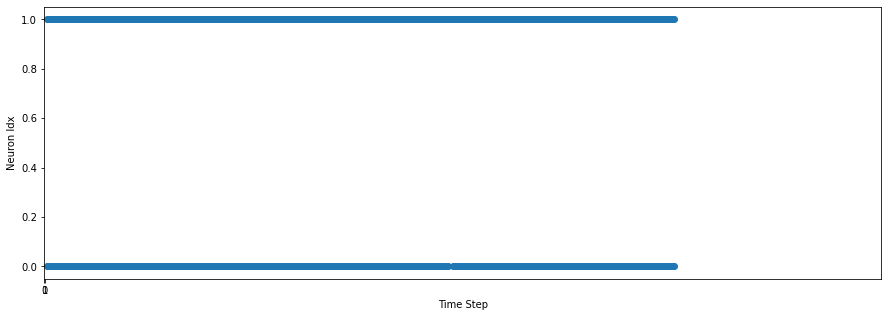

In [ ]:
# Run network
print("Running network")

source.run(condition=run_condition, run_cfg=run_config)
# Stop network execution
source.stop()